In [1]:
from artifacts_ipv6_sra_scanning.config import *
import pickle
import os
import ipaddress
import glob
import pycountry_convert as pycc
import country_converter as coco
from parallel_pandas import ParallelPandas
ParallelPandas.initialize(n_cpu=24, split_factor=1, disable_pr_bar=False)

2025-10-08 20:21:19.004 | INFO     | artifacts_ipv6_sra_scanning.config:<module>:22 - PROJ_ROOT path is: /home/service/artifacts-ipv6-sra-scanning


In [2]:
def map_iso3_to_continent(cc):
    if cc=='XK' or cc=='SXM':
        # kosovo is EU state, count saint marten as EU state (netherland territory)
        return 'EU'
    if cc=='UMI':
        #count umi states as US territory --> NA
        return 'NA'
    if cc=='TLS':
        # timor leste is asian state
        return 'AS'    
    alpha2 = pycc.country_alpha3_to_country_alpha2(cc)
    return pycc.country_alpha2_to_continent_code(alpha2) 

In [3]:
files = glob.glob(f'{INTERIM_DATA_DIR}/*.csv')

In [4]:
files = [file for file in files]

In [5]:
labels = ['SRA','Hitlist','ITDK','RIPE Atlas','IXP']

In [6]:
files

['/home/service/artifacts-ipv6-sra-scanning/data/interim/router-ips.csv',
 '/home/service/artifacts-ipv6-sra-scanning/data/interim/hitlist-ips.csv',
 '/home/service/artifacts-ipv6-sra-scanning/data/interim/itdk-ips.csv',
 '/home/service/artifacts-ipv6-sra-scanning/data/interim/ripe-ips.csv',
 '/home/service/artifacts-ipv6-sra-scanning/data/interim/ixp-ips.csv',
 '/home/service/artifacts-ipv6-sra-scanning/data/interim/init-ips-sra-tum-scan.csv',
 '/home/service/artifacts-ipv6-sra-scanning/data/interim/init-ips-sra-bgp48-scan.csv']

In [7]:
info_columns = ['Geo','AS-Number','BGP-Prefix','Org']

In [8]:
ipinfo_asn = pl.read_parquet('/home/service/ipinfos/ipinfo_asn.parquet')

In [9]:
ipinfo_asn = ipinfo_asn.with_columns(pl.col('asn').str.replace('AS','').cast(pl.Float64))

In [10]:
ipinfo_asn

network,asn,domain,name,type,country
str,f64,str,str,str,str
"""1.0.0.0/24""",13335.0,"""cloudflare.com""","""Cloudflare, Inc.""","""hosting""","""US"""
"""1.0.4.0/24""",38803.0,"""gtelecom.com.au""","""Gtelecom Pty Ltd""","""isp""","""AU"""
"""1.0.5.0/24""",38803.0,"""gtelecom.com.au""","""Gtelecom Pty Ltd""","""isp""","""AU"""
"""1.0.6.0/24""",38803.0,"""gtelecom.com.au""","""Gtelecom Pty Ltd""","""isp""","""AU"""
"""1.0.7.0/24""",38803.0,"""gtelecom.com.au""","""Gtelecom Pty Ltd""","""isp""","""AU"""
…,…,…,…,…,…
"""2c0f:ffa8::/32""",37057.0,"""vodacom.co.ls""","""Vodacom Lesotho (Pty) Ltd""","""isp""","""LS"""
"""2c0f:ffc8::/32""",22355.0,"""frogfoot.com""","""Frogfoot Networks""","""isp""","""ZA"""
"""2c0f:ffd0::/32""",36968.0,"""ecn.co.za""","""Electronic Communications Netw…","""isp""","""ZA"""


In [11]:
heatmap_data = pd.DataFrame()

for file,label in zip(files,labels):
    tmp = pl.read_csv(file,has_header=True,new_columns=['ip-addr', 'Geo', 'AS-Number', 'BGP-Prefix', 'Org'])
    tmp = tmp.filter(pl.col('ip-addr')!='saddr')
    router_asn = tmp.select(['Geo','AS-Number','ip-addr']).unique()
    router_asn = router_asn.join(ipinfo_asn.select(['asn','type']).unique(),how='left',left_on='AS-Number',right_on='asn')
    router_asn = router_asn.group_by(['Geo','type']).agg(pl.len().alias('count')).sort('count',descending=True)
    router_asn = router_asn.with_columns(
        pl.col("Geo").map_elements(map_iso3_to_continent, return_dtype=pl.Utf8).alias("Continent")
    ).filter((pl.col('Geo').is_not_null()) & (pl.col('Geo')!='ATA'))
    
    table = router_asn.group_by('type').agg(pl.col('count').sum().alias(label))
    order_types = ["ISP", "Hosting", "Business", "Education", "Government", "Unknown"]
    table = table.fill_null('Unknown').with_columns(
        pl.when(pl.col("type") == "isp")
          .then(pl.lit("ISP"))  # special case
          .otherwise(
              pl.col("type").str.slice(0,1).str.to_uppercase() + pl.col("type").str.slice(1).str.to_lowercase()
          )
          .alias("type")
    ).with_columns(
        pl.col("type").map_elements(lambda x: order_types.index(x), return_dtype=pl.Int32).alias("_sort_key")
    ).sort('_sort_key').drop('_sort_key').to_pandas().set_index('type')
    if heatmap_data.empty:
        heatmap_data = table
    else:
        heatmap_data = pd.concat([heatmap_data,table],axis=1)

In [12]:
heatmap_data = heatmap_data.div(heatmap_data.sum(axis=0), axis=1).mul(100).round(2).drop('Inactive',axis=0)

/home/service/artifacts-ipv6-sra-scanning/reports/figures/heatmap-network-types-all-sources.png


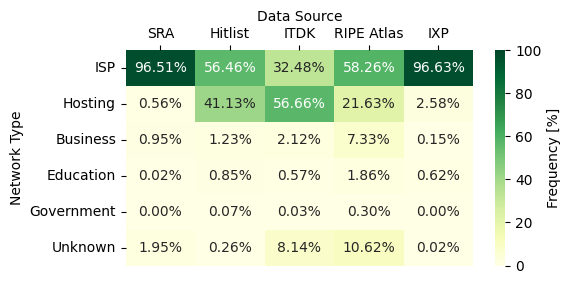

In [23]:
import seaborn as sns
import matplotlib.colors as mpc

figsize = (8*0.7,4*0.7)
fig,ax = vh.fig_ax(figsize)

annot_labels = heatmap_data.map(lambda x: f"{x:.2f}%")
sns.heatmap(heatmap_data,fmt="",
            linecolor='white',
            cmap='YlGn',
            annot=annot_labels,
            vmin=0,
            vmax=100,
            ax=ax,
            cbar_kws={'label': 'Frequency [%]',"orientation": "vertical","shrink":1,'location':'right'})
ax.set_ylabel('Network Type')
ax.xaxis.tick_top()
ax.set_xlabel('Data Source')
ax.xaxis.set_label_position('top')

vh.save_plot(fig,'heatmap-network-types-all-sources')

In [14]:
print(heatmap_data.to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrrrrr}
\toprule
 & SRA & Hitlist & ITDK & RIPE Atlas & IXP \\
type &  &  &  &  &  \\
\midrule
ISP & 96.51 & 56.46 & 32.48 & 58.26 & 96.63 \\
Hosting & 0.56 & 41.13 & 56.66 & 21.63 & 2.58 \\
Business & 0.95 & 1.23 & 2.12 & 7.33 & 0.15 \\
Education & 0.02 & 0.85 & 0.57 & 1.86 & 0.62 \\
Government & 0.00 & 0.07 & 0.03 & 0.30 & 0.00 \\
Unknown & 1.95 & 0.26 & 8.14 & 10.62 & 0.02 \\
\bottomrule
\end{tabular}

